# PROJET 7 : IMPLÉMENTEZ UN MODÈLE DE SCORING

## 0 - PRÉALABLES :

### A - Importation des librairies :

In [1]:
# no warnings :
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# basics :
import numpy as np
import pandas as pd
import re
import gc
from contextlib import contextmanager
from math import pi

# models, model selection & metrics
from lightgbm import LGBMClassifier
from lightgbm import create_tree_digraph
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
import shap

# Visualisation :
import matplotlib.pyplot as plt
import seaborn as sns

# Export
import joblib

### B) Commentaires sur l'utilisation d'un Kernel Kaggle :

https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

## I - FEATURES ENGINEERING (VIA KERNEL KAGGLE) :

### A - Préalables :

#### 1) Définition du répertoire :

In [4]:
# définition du répertoire :
path = "C:/Users/7700k/Desktop/Openclassrooms/Implémentez un modèle de scoring/dataset/"

#### 2) Fonction d'encodage "one hot encoder" :

In [34]:
# Fonction d'encodage :
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == "object"]
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

### B - Import et traitement des fichiers (via un kernel Kaggle) :

#### 1) "application_train" & "application_test :

In [47]:
# Importation et transformation de application_train et application_test :
def application_train_test(num_rows = None, nan_as_category = False):
    
    # Read data and merge
    df = pd.read_csv(path + "application_train.csv", nrows= num_rows)
    test_df = pd.read_csv(path + "application_test.csv", nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    
    # Remove "CODE_GENDER"
    df.drop(columns=["CODE_GENDER"], inplace=True)
    test_df.drop(columns=["CODE_GENDER"], inplace=True)
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ["FLAG_OWN_CAR", "FLAG_OWN_REALTY"]:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
        
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df["DAYS_EMPLOYED"].replace(365243, np.nan, inplace= True)
    
    # Some simple new features (percentages)
    df["DAYS_EMPLOYED_PERC"] = df["DAYS_EMPLOYED"] / df["DAYS_BIRTH"]
    df["INCOME_CREDIT_PERC"] = df["AMT_INCOME_TOTAL"] / df["AMT_CREDIT"]
    df["INCOME_PER_PERSON"] = df["AMT_INCOME_TOTAL"] / df["CNT_FAM_MEMBERS"]
    df["ANNUITY_INCOME_PERC"] = df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"]
    df["PAYMENT_RATE"] = df["AMT_ANNUITY"] / df["AMT_CREDIT"]
    del test_df
    gc.collect()
    return df

#### 2) "bureau" & "bureau_balance" :

In [36]:
# Importation et transformation de bureau et bureau_balance :
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(path + "bureau.csv", nrows = num_rows)
    bb = pd.read_csv(path + "bureau_balance.csv", nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {"MONTHS_BALANCE" : ["min", "max", "size"]}
    for col in bb_cat:
        bb_aggregations[col] = ["mean"]
    bb_agg = bb.groupby("SK_ID_BUREAU").agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how="left", on="SK_ID_BUREAU")
    bureau.drop(["SK_ID_BUREAU"], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        "DAYS_CREDIT" : ["min", "max", "mean", "var"],
        "DAYS_CREDIT_ENDDATE" : ["min", "max", "mean"],
        "DAYS_CREDIT_UPDATE" : ["mean"],
        "CREDIT_DAY_OVERDUE" : ["max", "mean"],
        "AMT_CREDIT_MAX_OVERDUE" : ["mean"],
        "AMT_CREDIT_SUM" : ["max", "mean", "sum"],
        "AMT_CREDIT_SUM_DEBT" : ["max", "mean", "sum"],
        "AMT_CREDIT_SUM_OVERDUE" : ["mean"],
        "AMT_CREDIT_SUM_LIMIT" : ["mean", "sum"],
        "AMT_ANNUITY" : ["max", "mean"],
        "CNT_CREDIT_PROLONG" : ["sum"],
        "MONTHS_BALANCE_MIN" : ["min"],
        "MONTHS_BALANCE_MAX" : ["max"],
        "MONTHS_BALANCE_SIZE" : ["mean", "sum"]
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ["mean"]
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ["mean"]
    
    bureau_agg = bureau.groupby("SK_ID_CURR").agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(["BURO_" + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau["CREDIT_ACTIVE_Active"] == 1]
    active_agg = active.groupby("SK_ID_CURR").agg(num_aggregations)
    active_agg.columns = pd.Index(["ACTIVE_" + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how="left", on="SK_ID_CURR")
    del active, active_agg
    gc.collect()

    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau["CREDIT_ACTIVE_Closed"] == 1]
    closed_agg = closed.groupby("SK_ID_CURR").agg(num_aggregations)
    closed_agg.columns = pd.Index(["CLOSED_" + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how="left", on="SK_ID_CURR")
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

#### 3) "previous_applications" :

In [37]:
# Importation et transformation de bureau et bureau_balance :
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(path + "previous_application.csv", nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    
    # Days 365.243 values -> nan
    prev["DAYS_FIRST_DRAWING"].replace(365243, np.nan, inplace= True)
    prev["DAYS_FIRST_DUE"].replace(365243, np.nan, inplace= True)
    prev["DAYS_LAST_DUE_1ST_VERSION"].replace(365243, np.nan, inplace= True)
    prev["DAYS_LAST_DUE"].replace(365243, np.nan, inplace= True)
    prev["DAYS_TERMINATION"].replace(365243, np.nan, inplace= True)
    
    # Add feature: value ask / value received percentage
    prev["APP_CREDIT_PERC"] = prev["AMT_APPLICATION"] / prev["AMT_CREDIT"]
    
    # Previous applications numeric features
    num_aggregations = {
        "AMT_ANNUITY" : ["min", "max", "mean"],
        "AMT_APPLICATION" : ["min", "max", "mean"],
        "AMT_CREDIT" : ["min", "max", "mean"],
        "APP_CREDIT_PERC" : ["min", "max", "mean", "var"],
        "AMT_DOWN_PAYMENT" : ["min", "max", "mean"],
        "AMT_GOODS_PRICE" : ["min", "max", "mean"],
        "HOUR_APPR_PROCESS_START" : ["min", "max", "mean"],
        "RATE_DOWN_PAYMENT" : ["min", "max", "mean"],
        "DAYS_DECISION" : ["min", "max", "mean"],
        "CNT_PAYMENT" : ["mean", "sum"],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ["mean"]
    
    prev_agg = prev.groupby("SK_ID_CURR").agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(["PREV_" + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev["NAME_CONTRACT_STATUS_Approved"] == 1]
    approved_agg = approved.groupby("SK_ID_CURR").agg(num_aggregations)
    approved_agg.columns = pd.Index(["APPROVED_" + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how="left", on="SK_ID_CURR")
    
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev["NAME_CONTRACT_STATUS_Refused"] == 1]
    refused_agg = refused.groupby("SK_ID_CURR").agg(num_aggregations)
    refused_agg.columns = pd.Index(["REFUSED_" + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how="left", on="SK_ID_CURR")
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

#### 4) "POS_CASH_balance" :

In [38]:
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(path + "POS_CASH_balance.csv", nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)

    # Features
    aggregations = {
        "MONTHS_BALANCE" : ["max", "mean", "size"],
        "SK_DPD" : ["max", "mean"],
        "SK_DPD_DEF" : ["max", "mean"]
    }
    for cat in cat_cols:
        aggregations[cat] = ["mean"]
    
    pos_agg = pos.groupby("SK_ID_CURR").agg(aggregations)
    pos_agg.columns = pd.Index(["POS_" + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # Count pos cash accounts
    pos_agg["POS_COUNT"] = pos.groupby("SK_ID_CURR").size()
    del pos
    gc.collect()
    return pos_agg

#### 5) "installments_payments" :

In [39]:
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(path + "installments_payments.csv", nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins["PAYMENT_PERC"] = ins["AMT_PAYMENT"] / ins["AMT_INSTALMENT"]
    ins["PAYMENT_DIFF"] = ins["AMT_INSTALMENT"] - ins["AMT_PAYMENT"]
    
    # Days past due and days before due (no negative values)
    ins["DPD"] = ins["DAYS_ENTRY_PAYMENT"] - ins["DAYS_INSTALMENT"]
    ins["DBD"] = ins["DAYS_INSTALMENT"] - ins["DAYS_ENTRY_PAYMENT"]
    ins["DPD"] = ins["DPD"].apply(lambda x: x if x > 0 else 0)
    ins["DBD"] = ins["DBD"].apply(lambda x: x if x > 0 else 0)

    # Features: Perform aggregations
    aggregations = {
        "NUM_INSTALMENT_VERSION" : ["nunique"],
        "DPD" : ["max", "mean", "sum"],
        "DBD" : ["max", "mean", "sum"],
        "PAYMENT_PERC" : ["max", "mean", "sum", "var"],
        "PAYMENT_DIFF" : ["max", "mean", "sum", "var"],
        "AMT_INSTALMENT" : ["max", "mean", "sum"],
        "AMT_PAYMENT" : ["min", "max", "mean", "sum"],
        "DAYS_ENTRY_PAYMENT" : ["max", "mean", "sum"]
    }
    for cat in cat_cols:
        aggregations[cat] = ["mean"]
    ins_agg = ins.groupby("SK_ID_CURR").agg(aggregations)
    ins_agg.columns = pd.Index(["INSTAL_" + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

    # Count installments accounts
    ins_agg["INSTAL_COUNT"] = ins.groupby("SK_ID_CURR").size()
    del ins
    gc.collect()
    return ins_agg

#### 6) "credit_card_balance" :

In [40]:
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(path + "credit_card_balance.csv", nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    
    # General aggregations
    cc.drop(["SK_ID_PREV"], axis= 1, inplace = True)
    cc_agg = cc.groupby("SK_ID_CURR").agg(["min", "max", "mean", "sum", "var"])
    cc_agg.columns = pd.Index(["CC_" + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    # Count credit card lines
    cc_agg["CC_COUNT"] = cc.groupby("SK_ID_CURR").size()
    del cc
    gc.collect()
    return cc_agg

#### 7) Jointures des différents dataframes :

In [49]:
def main(debug = False):
    num_rows = 10000 if debug else None
    
    df = application_train_test(num_rows)
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how="left", on="SK_ID_CURR")
    del bureau
    gc.collect()
    
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how="left", on="SK_ID_CURR")
    del prev
    gc.collect()
    
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how="left", on="SK_ID_CURR")
    del pos
    gc.collect()
    
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how="left", on="SK_ID_CURR")
    del ins
    gc.collect()

    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how="left", on="SK_ID_CURR")
    del cc
    gc.collect()
    
    df = df.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
    
    df.to_csv("data.csv")
    
    return df

## II - MODÈLISATION (LIGHTGBM VIA KERNEL KAGGLE) 

### A - Création et récupération du modèle :

#### 1) Traitement du dataframe et initialisation du modèle :

In [50]:
def kfold_lightgbm(df=main(), num_folds=10, stratified = False, debug= False):
    
    # Divide in training/validation data
    train_df = df[df["TARGET"].notnull()]
    print("Starting LightGBM. Train shape: {}".format(train_df.shape))
    del df
    gc.collect()
    
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    
    feats = [f for f in train_df.columns if f not in ["TARGET", "SK_ID_CURR", "SK_ID_BUREAU", "SK_ID_PREV", "index"]]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df["TARGET"])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df["TARGET"].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df["TARGET"].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= "auc", verbose= 200, early_stopping_rounds= 200)
        
        # Model export
        joblib.dump(clf, "LGBM_model")

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Previous applications df shape: (338857, 249)
Pos-cash balance df shape: (337252, 18)
Installments payments df shape: (339587, 26)
Credit card balance df shape: (103558, 141)


#### 2) Entraînement et récupération du modèle :

In [51]:
# Entraînement et récupération du modèle :
kfold_lightgbm()

Starting LightGBM. Train shape: (307511, 797)
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.795395	training's binary_logloss: 0.235181	valid_1's auc: 0.773771	valid_1's binary_logloss: 0.248893
[400]	training's auc: 0.81805	training's binary_logloss: 0.225737	valid_1's auc: 0.785248	valid_1's binary_logloss: 0.244486
[600]	training's auc: 0.832875	training's binary_logloss: 0.219776	valid_1's auc: 0.788955	valid_1's binary_logloss: 0.243059
[800]	training's auc: 0.845075	training's binary_logloss: 0.214766	valid_1's auc: 0.790418	valid_1's binary_logloss: 0.242568
[1000]	training's auc: 0.855845	training's binary_logloss: 0.210297	valid_1's auc: 0.791136	valid_1's binary_logloss: 0.242235
[1200]	training's auc: 0.865647	training's binary_logloss: 0.206085	valid_1's auc: 0.79168	valid_1's binary_logloss: 0.241984
[1400]	training's auc: 

Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.795549	training's binary_logloss: 0.235737	valid_1's auc: 0.771512	valid_1's binary_logloss: 0.243624
[400]	training's auc: 0.818054	training's binary_logloss: 0.226271	valid_1's auc: 0.782239	valid_1's binary_logloss: 0.239369
[600]	training's auc: 0.833229	training's binary_logloss: 0.220122	valid_1's auc: 0.786339	valid_1's binary_logloss: 0.237933
[800]	training's auc: 0.84573	training's binary_logloss: 0.215047	valid_1's auc: 0.788351	valid_1's binary_logloss: 0.237246
[1000]	training's auc: 0.856632	training's binary_logloss: 0.210486	valid_1's auc: 0.788926	valid_1's binary_logloss: 0.237032
[1200]	training's auc: 0.86619	training's binary_logloss: 0.206331	valid_1's auc: 0.789149	valid_1's binary_logloss: 0.236958
Early stopping, best iteration is:
[1146]	training's auc: 0.863739	training's binary_logloss: 0.207409	valid_1's auc: 0.789337	valid_1's binary_logloss: 0.236912
Training until valid

## III - ÉVALUATION DU MODÈLE :

### A - Récupération du modèle et du dataset corrigé :

#### 1) Chargement du modèle :

In [5]:
# Chargement du modèle :
model = joblib.load(path + "LGBM_model")

#### 2) Récupération du dataset nettoyé :

In [6]:
# Récupération du dataset de test :
data = pd.read_csv(path + "data.csv",index_col=[0])

#### 3) Récupération de y_train et y_predict :

In [7]:
# Récupération de y_test et y_pred :
datascore = data[~data["TARGET"].isnull()]
y_train = datascore["TARGET"]
feats = [f for f in data.columns if f not in ["TARGET", "SK_ID_CURR", "SK_ID_BUREAU", "SK_ID_PREV", "index"]]
y_pred = model.predict(datascore[feats])

### B - Performances du modèle :

#### 1) Résultats bruts :

In [7]:
# Scores du modèle :
cm = confusion_matrix(y_train, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[282188    498]
 [ 22634   2191]]

True Positives(TP) =  282188

True Negatives(TN) =  2191

False Positives(FP) =  498

False Negatives(FN) =  22634


#### 2) Heatmap :

<AxesSubplot:>

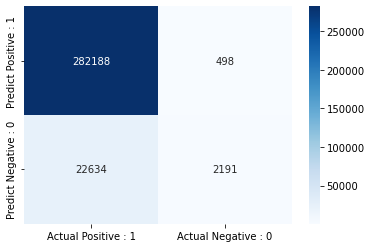

In [8]:
# Heatmap :
df_cm = pd.DataFrame(data = cm, columns=['Actual Positive : 1', 'Actual Negative : 0'], 
                     index=['Predict Positive : 1', 'Predict Negative : 0'])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")

#### 3) Tableau des scores :

In [9]:
# Scores :
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    282686
         1.0       0.81      0.09      0.16     24825

    accuracy                           0.92    307511
   macro avg       0.87      0.54      0.56    307511
weighted avg       0.92      0.92      0.90    307511



#### 4) Courbe ROC et ROC AUC Score :

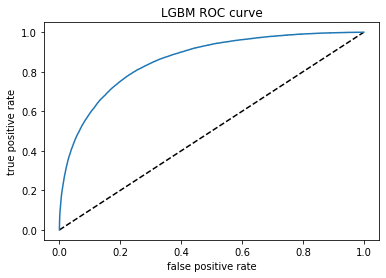

roc_auc_score :  0.8594611116455945


In [16]:
# Courbe ROC et ROC AUC Score :
y_pred_proba = model.predict_proba(datascore[feats])[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='LGBM')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title(f'LGBM ROC curve')
plt.show()

print("roc_auc_score : ", roc_auc_score(y_train, y_pred_proba))

### B) Explicabilité du modèle (SHAP) :

#### 1) Exemple d'arbre de décision :

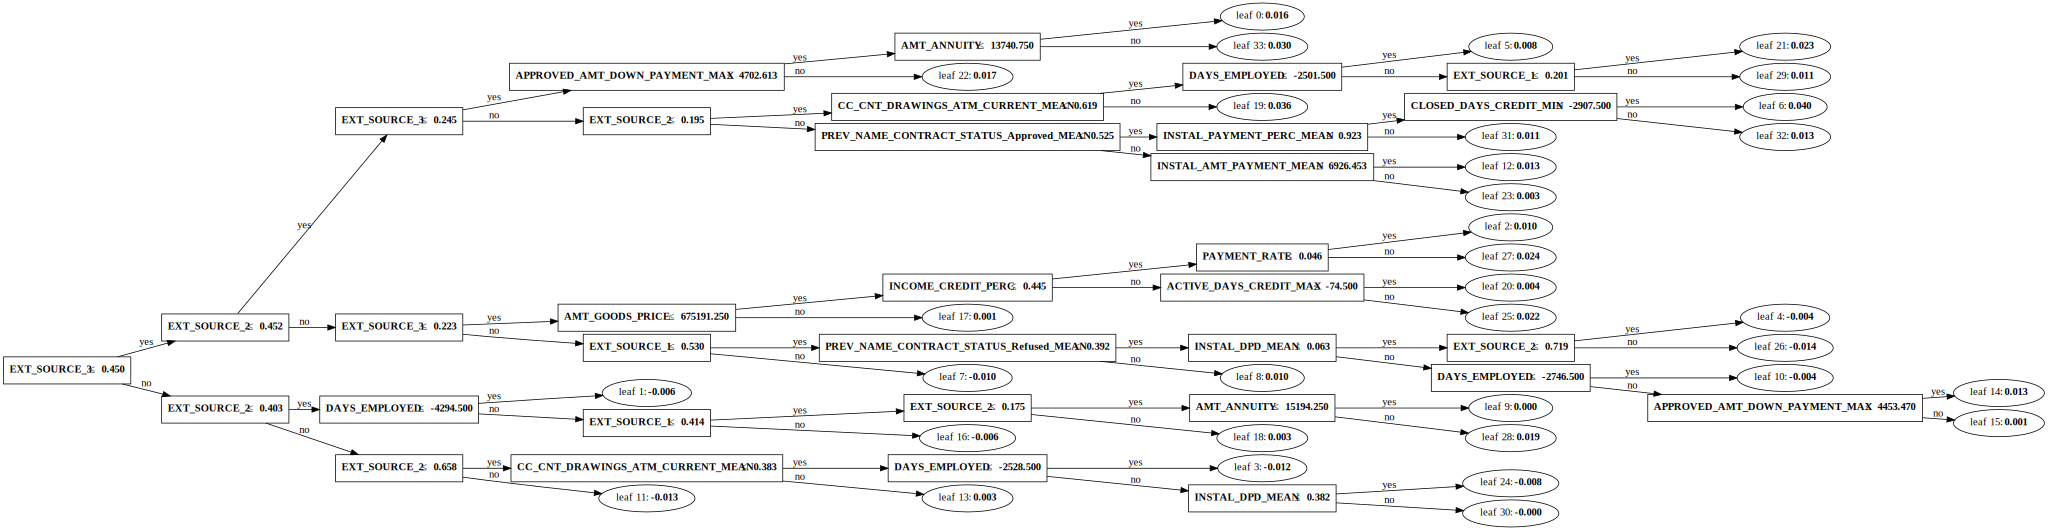

In [25]:
# Exemple d'un arbre de décision :
create_tree_digraph(model, tree_index=20)

#### 2) Calcul de l'explicateur Shap :

In [16]:
# Récupération de l'échantillon non étiquetté :
test = data[data["TARGET"].isnull()][feats]

In [13]:
# XAI (SHAP) :
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


#### 3) Influence des variables :

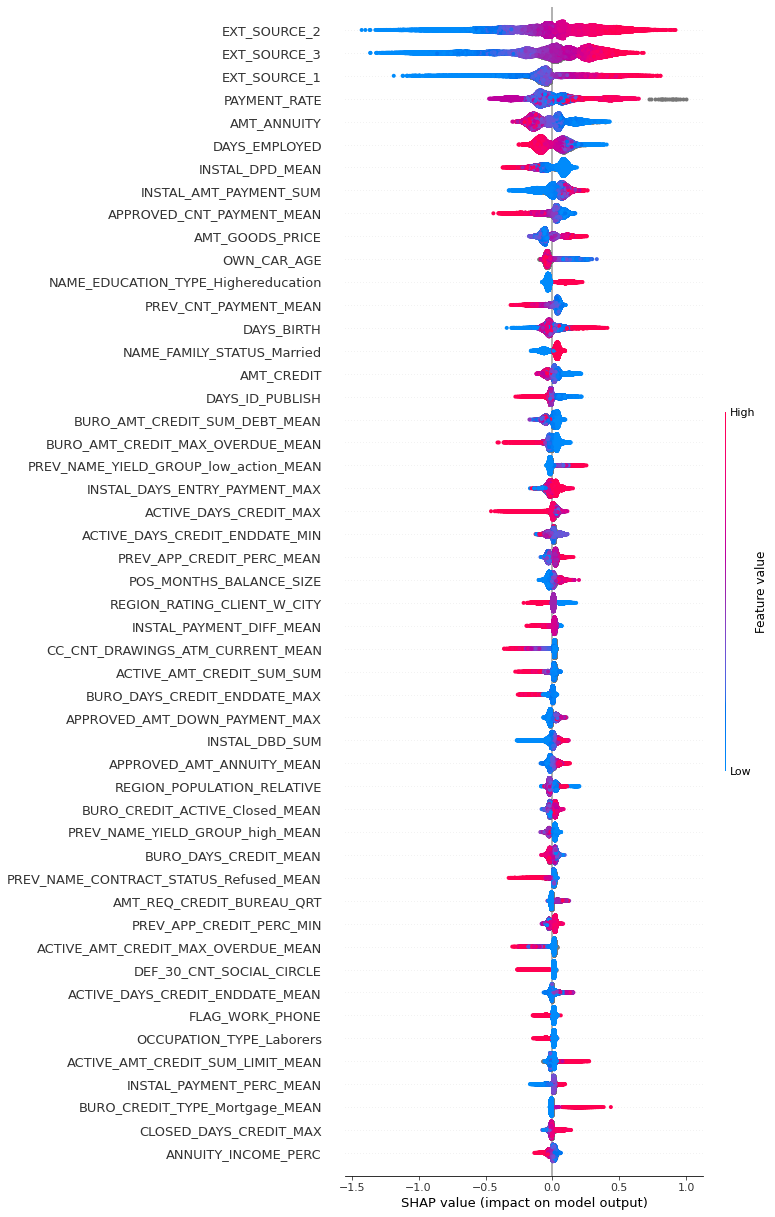

In [17]:
# Influence des variables (summary_plot):
shap.summary_plot(shap_values[0][:], test, max_display=50)

#### 4) Exemple d'explication individuelle :

In [18]:
# Explications individuelles (prédiction de défaut de paiement):
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][253,:], test.iloc[253])

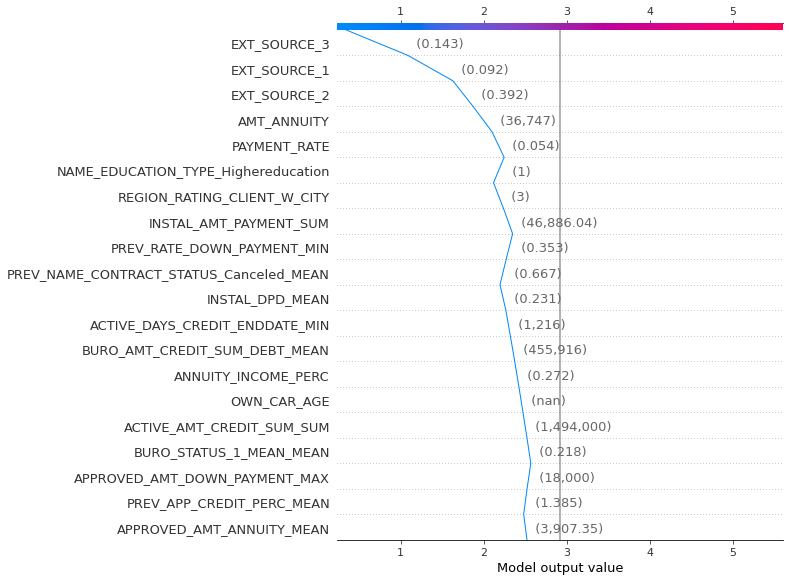

In [16]:
# Influence des variables (prédiction de défaut de paiement):
shap.decision_plot(explainer.expected_value[0] , shap_values[0][253,:], test.iloc[253])

In [19]:
# Explications individuelles (prédiction de remboursement):
shap.force_plot(explainer.expected_value[0], shap_values[0][20,:], test.iloc[20])

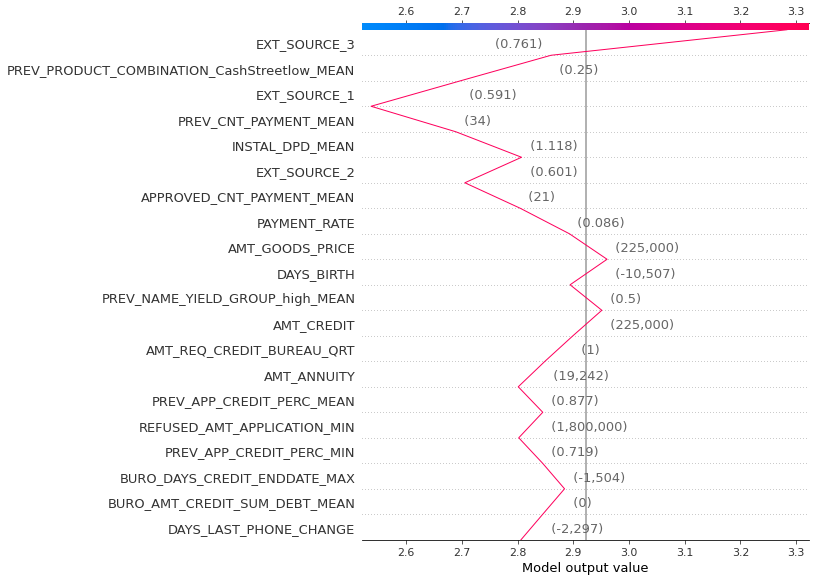

In [18]:
# Influence des variables (prédiction de défaut de paiement):
shap.decision_plot(explainer.expected_value[0] , shap_values[0][20,:], test.iloc[20])

## IV - PRÉPARATION DU DASHBOARD DE L'API :

### A - Importation des librairies et de fichiers nécessaires :

#### 1) Importation des librairies :

In [8]:
# Import des librairies :
import pandas as pd
import streamlit as st
import matplotlib.pyplot as plt
import joblib
from math import pi

#### 2) Importation du scaler et du modèle :

In [9]:
# Import du fichier et du modèle :
path = "C:/Users/7700k/Desktop/Openclassrooms/Implémentez un modèle de scoring/dataset/"
model = joblib.load(path +"LGBM_model")

#### 3) Constitution d'un dataset de démonstration pour l'API :

In [10]:
# Constitution du dataset demo :
data_api = data[data["TARGET"].isnull()].drop(columns=["index"])

# Prédiction de la target :
data_api["TARGET"] = model.predict(data_api.drop(columns=["SK_ID_CURR","TARGET"]))

# Récupération de 10 individus dont la prédiction est positive :
data_api_yes = data_api[data_api["TARGET"]==0][:10]

# Récupération de 10 individus dont la prédiction est négative :
data_api_no = data_api[data_api["TARGET"]==1][:10]

# Jointure des deux groupes :
data_api = pd.concat([data_api_yes, data_api_no])

# Suppression des informations de TARGET :
data_api["TARGET"] = np.nan

# Récupération du data
data_api.to_csv(path + "data_api.csv")

### B - Création du dashboard (Streamlit) :

#### 1) Configuration du tableau de bord :

In [ ]:
# Configuration du tableau de bord :
st.set_page_config(
    page_title="Moteur de recommandation crédit",
    layout="wide")

#### 2) Configuration de l'interface :

In [ ]:
# Titre :
st.markdown("<h1 style='text-align: center; color: #5A5E6B;'>ANALYSE DU DOSSIER</h1>", unsafe_allow_html=True)

# Filtre :
id_filter = st.selectbox("Entrez identifiant client", pd.unique(df["SK_ID_CURR"]))

# Filtrage du Dataframe :
df = df[df["SK_ID_CURR"] == id_filter]

#### 3) Affichage de la prédiction :

In [ ]:
# Affichage de la prédiction :
prediction = int(model.predict(df.drop(columns=["TARGET","SK_ID_CURR"])))
proba = model.predict_proba(df.drop(columns=["TARGET","SK_ID_CURR"]))
proba = round(proba[0][0]*100,1)

if prediction == 0 :
    prob, pred = st.columns(2)
    with prob :
        st.success(f"Probabilités de remboursement : {proba} %")
    with pred :
        st.markdown("<h2 style='text-align: center; color: #44be6e;'>AVIS FAVORABLE</h2>", unsafe_allow_html=True)

else :
    prob, pred = st.columns(2)
    with prob :
        st.error(f"Probabilités de remboursement : {proba} %")
    with pred :
        st.markdown("<h2 style='text-align: center; color: #ff3d41;'>AVIS DÉFAVORABLE</h2>", unsafe_allow_html=True)
        # exemple de prêt refusé : ID=104410

#### 4) Affichage des KPI :

In [ ]:
# Création d'une ligne de KPI
age, revenus, montant_credit, duree_credit, montant_annuite = st.columns(5)

# Définition des KPI
age.metric(label="Age", value=f"{abs(int(round(df.DAYS_BIRTH/365,25)))} ans")
revenus.metric(label="revenus annuels", value=f"{int(round(df.AMT_INCOME_TOTAL))} $")
montant_credit.metric(label="Crédit demandé", value= f"{int(round(df.AMT_CREDIT))} $")
duree_credit.metric(label="Durée du crédit", value=f"{int(round(1/df.PAYMENT_RATE))} ans")
montant_annuite.metric(label="Montant des annuités", value=f"{int(round(df.AMT_ANNUITY))} $")

#### 5) Tableau des scores :

In [ ]:
# Tableau de scores
all_features, score1, score2, score3 = st.columns(4)

with all_features :
    id_filter_features = st.selectbox("Toutes informations", pd.unique(df.columns))
    feature = df[id_filter_features]
    all_features.metric(label=id_filter_features, value=feature)

with score1 :
    if df["EXT_SOURCE_1"].isna().values :
        st.markdown("<h3 style='text-align: center; color: #ff3d41;'>Score 1 non renseigné</h3>", unsafe_allow_html=True)
    else :
        val = [(1-float(df["EXT_SOURCE_1"])), float(df["EXT_SOURCE_1"])]
        val.append(sum(val))
        colors = ["#ff3d41","#44be6e","white"]
        fig1, ax1 = plt.subplots()
        ax1.pie(val, colors=colors)
        ax1.add_artist(plt.Circle((0, 0), 0.6, color='white'))
        ax1.axis("equal")
        plt.title("Score 1")
        st.pyplot(fig1)

with score2 :
    if df["EXT_SOURCE_2"].isna().values :
        st.markdown("<h3 style='text-align: center; color: #ff3d41;'>Score 2 non renseigné</h3>", unsafe_allow_html=True)
    else :
        val = [(1-float(df["EXT_SOURCE_2"])), float(df["EXT_SOURCE_2"])]
        val.append(sum(val))
        colors = ["#ff3d41","#44be6e","white"]
        fig1, ax1 = plt.subplots()
        ax1.pie(val, colors=colors)
        ax1.add_artist(plt.Circle((0, 0), 0.6, color='white'))
        ax1.axis("equal")
        plt.title("Score 2")
        st.pyplot(fig1)

with score3 :
    if df["EXT_SOURCE_3"].isna().values :
        st.markdown("<h3 style='text-align: center; color: #ff3d41;'>Score 3 non renseigné</h3>", unsafe_allow_html=True)
    else :
        val = [(1-float(df["EXT_SOURCE_3"])), float(df["EXT_SOURCE_3"])]
        val.append(sum(val))
        colors = ["#ff3d41","#44be6e","white"]
        fig1, ax1 = plt.subplots()
        ax1.pie(val, colors=colors)
        ax1.add_artist(plt.Circle((0, 0), 0.6, color='white'))
        ax1.axis("equal")
        plt.title("Score 3")
        st.pyplot(fig1)

#### 6) Radar :

In [15]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit(df[["PAYMENT_RATE","AMT_ANNUITY","DAYS_EMPLOYED","INSTAL_DPD_MEAN","DAYS_BIRTH","AMT_GOODS_PRICE"]])
# joblib.dump(scaler, "Scaler")
scaler = joblib.load(path + "Scaler")

In [17]:
# MinMax() :
df_MM = data_api[["PAYMENT_RATE","AMT_ANNUITY","DAYS_EMPLOYED","INSTAL_DPD_MEAN","DAYS_BIRTH","AMT_GOODS_PRICE"]]
df_MM = pd.DataFrame(scaler.transform(df_MM), columns=df_MM.columns)

In [22]:
# Score moyen :
df_mean = df[["PAYMENT_RATE","AMT_ANNUITY","DAYS_EMPLOYED","INSTAL_DPD_MEAN","DAYS_BIRTH","AMT_GOODS_PRICE"]]
df_mean = pd.DataFrame(scaler.transform(df_mean), columns=df_mean.columns)

In [23]:
# set data :
radar = pd.DataFrame({
    "Groupe" : ["Client", "Moyenne défaut de paiement"],
    "Rythme paiement" : [df_MM["PAYMENT_RATE"].fillna(0)[0], df_mean["PAYMENT_RATE"].mean()],
    "Montant des annuités" : [1 - df_MM["AMT_ANNUITY"].fillna(0)[0], 1 - df_mean["AMT_ANNUITY"].mean()],
    "Récence de l'emploi" : [1 - df_MM["DAYS_EMPLOYED"].fillna(0)[0], 1 - df_mean["DAYS_EMPLOYED"].mean()],
    "Fiabilité paiement" : [1 - df_MM["INSTAL_DPD_MEAN"].fillna(0)[0], 1 - df_mean["INSTAL_DPD_MEAN"].mean()], 
    "Jeunesse" : [df_MM["DAYS_BIRTH"].fillna(0)[0], df_mean["DAYS_BIRTH"].mean()],  
    "Montant des biens achetés" : [df_MM["AMT_GOODS_PRICE"].fillna(0)[0], df_mean["AMT_GOODS_PRICE"].mean()]
    })

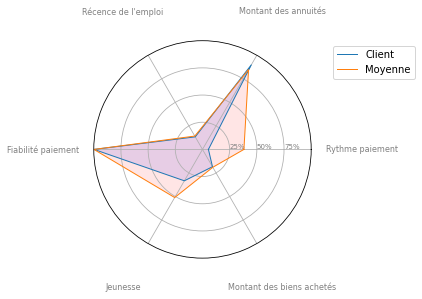

In [24]:
# Initialisation de la figure :
fig, ax = plt.subplots()

# Nombre de variables :
categories=list(radar)[1:]
N = len(categories)

# Nous allons tracer la première ligne du bloc de données.
# Mais nous devons répéter la première valeur pour fermer le graphique circulaire :
values=radar.loc[0].drop("Groupe").values.flatten().tolist()
values += values[:1]

# Quel sera l'angle de chaque axe ?
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialisation du radar :
ax = plt.subplot(111, polar=True)

# Trace un axe par variable et ajoute les libélés :
plt.xticks(angles[:-1], categories, color='grey', size=8)
ax.tick_params(axis='x', which='major', pad=40)

# Tracé
ax.set_rlabel_position(0)
plt.yticks([0.25,0.5,0.75], ["25%","50%","75%"], color="grey", size=7)
plt.ylim(0,1)

# Indicateur 1
values=radar.loc[0].drop("Groupe").values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Client")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Indicateur 2
values=radar.loc[1].drop("Groupe").values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Moyenne")
ax.fill(angles, values, 'r', alpha=0.1)
 
# Légende
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

# Affichage
plt.show()

#### 7) Rapport Crédit - Salaire :

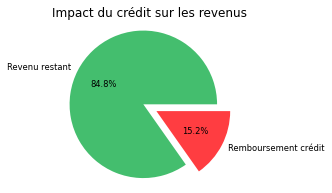

In [25]:
# Pieplot revenus :
labels=["Revenu restant","Remboursement crédit"]
values=[df["AMT_INCOME_TOTAL"].iloc[0] - df["AMT_ANNUITY"].iloc[0] , df["AMT_ANNUITY"].iloc[0]]
colors = "#44be6e", "#ff3d41"
explode = (0,0.2)

fig1, ax1 = plt.subplots(figsize=(4,3))
plt.title("Impact du crédit sur les revenus")
ax1.pie(values, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', textprops={"size":"smaller"})
ax1.axis("equal")
plt.show()